# CA683 Data Mining Assignment 1

_Disclaimer: Submitted to Dublin City University, School of Computing for module CA683, 2016. We hereby certify that the work presented and the material contained herein is our own except where explicitly stated references to other material are made_.

**Authors**: John Segrave, Claire Breslin, Paul, O'Hara

### Table of Contents
1. [Problem recognition and framing](#1.-Problem-recognition-and-framing)
1. [Review of previous findings](#2.-Review-of-previous-findings)
1. [Modelling and variable selection](#3.-Modelling-and-variable-selection)
1. [Data collection](#4.-Data-collection)
1. [Data analysis](#5.-Data-analysis)
1. [Results presentation and action](#6.-Results-presentation-and-action)
1. [REFERENCES](#REFERENCES)

# 1. Problem recognition and framing
__Problem statement__: _"Botanists require you to help them design an algorithm to identify flower types from 4 key measurements."_

This is a straightforward classification problem.  Given that a flower is already known to be an Iris, can we classify which _type_ of Iris it is (Setosa, Versicolor or Virginica) given a few simple measurements?

#### Notebook Admin
Ideally, we would hide all of the code in this notebook and focus only on the narrative. However, IPython/Jupyter doesn't support code hiding yet. So to minimise the space taken up by code, it is condensed onto one line where practical, as below.

In [23]:
%matplotlib inline
import pandas as pd; import seaborn as sns; import matplotlib.pyplot as plt; from sklearn import tree; from sklearn.tree import DecisionTreeClassifier; from sklearn.cross_validation import train_test_split; from sklearn.externals.six import StringIO; from sklearn import cross_validation; from sklearn import  preprocessing; import pydot_ng; from IPython.display import Image; from sklearn.metrics import accuracy_score

# 2. Review of previous findings

The Iris dataset (Fisher 1936) is widely-used for teaching statistical data analysis and machine learning. There are an enormous number of analyses available in print and online. Examples include:
1. Warwick University [Linear Regression](http://www2.warwick.ac.uk/fac/sci/moac/people/students/peter_cock/r/iris_lm/) teaching materials. 
1. [Kaggle](https://www.kaggle.com/uciml/iris) data analysis tutorials. 
1. ['SciPy' Scientific computing library documentation](http://www.scipy-lectures.org/packages/statistics/auto_examples/plot_iris_analysis.html)

# 3. Modelling and variable selection

The variables are all provided in the dataset and all look potentially relevant to the classification problem. There is no scope to obtain any other variables that we might believe relevant to the problem (e.g. the flower's predominant colour).

### Available Data
The dataset confirms to the 'Tidy Data' principles (Wickham, 2014):
* Each row in the dataset = one observation of a flower.
* Each column = one variable relating to that flower. Four are measurements - the lengths and widths of the flower's petals and sepals. The fifth is the flower's type (nominal: Setosa, Versicolor or Virginica), which will be the dependent variable in our analysis.

### Known Limitations
The Setosas are linearly separable from the other two species, but the Versicolors and Virginicas cannot be linearly  separated ([Kaggle](https://www.kaggle.com/uciml/eiris)).

### Example Row

In [24]:
rawdata = pd.read_csv('./iris_with_missing_data.csv'); rawdata.head(1)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa


# 4. Data collection
The data is a given, no collection was required.

# 5. Data analysis

## 5.1 Data Cleaning - Missing Values
There are a few missing values, but not so many as to be a problem for our analysis (less than 5% in any column). We don't want to delete them, as we'd lose 10% of the Setosa information, so instead we'll impute the missing values from the data.

Consider the two missing Petal.Length values - we have many options to impute these. For example:
* _Simple:_ use the overall Petal.Length mean (3.8) for both data points.
* _Class-based:_ use the mean of the relevant flower type for each data point (1.5 and 5.6 respectively).
* _'Personalised':_ find the 'nearest-neighbours' of each data point and use their mean (1.4 and 5.1 respectively, using 5-NN and Euclidean distance).

These are all markedly different from each other. However, it usually makes sense to start simply and add complexity only where it is needed. So we will start with the simple 'overall mean' option. We may return to this depending on how the rest of the analysis goes.

In [25]:
null_counts = rawdata.isnull().sum()
nulls = pd.concat([null_counts, (null_counts * 100) / rawdata.shape[0], rawdata.mean()], axis=1, join='inner'); nulls.columns = ['Missing (count)', 'Missing (%)', 'Replaced With Mean']
print(nulls.iloc[null_counts.nonzero()])
data = rawdata.fillna(rawdata.mean()) # simple missing-value treatment - use the overall mean

              Missing (count)  Missing (%)  Replaced With Mean
Sepal.Length                4     2.666667            5.834932
Sepal.Width                 5     3.333333            3.051034
Petal.Length                2     1.333333            3.766892


## 5.2 Univariate statistics to describe the data

### Raw Statistics
The obvious univariate statistics of relevance to our problem are the mean, median, standard deviation and range of each distinct species. (The overall statistics, not taking species into account, are not particularly useful for this problem).

We could show the raw numbers for these - for example, here they are for the Setosa species:

In [26]:
description = data[data['Species']=='setosa'].describe().drop(['count', '25%', '75%']); description # would be useful towork out how to change the row axis names e.g. description.axes[0] = ['Mean', 'Std Dev', 'Min', 'Median', 'Max']

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
mean,5.033397,3.397062,1.515338,0.246000
std,0.388047,0.382123,0.364693,0.105386
min,4.300000,2.300000,1.000000,0.100000
50%,5.000000,3.400000,1.500000,0.200000
max,5.834932,4.400000,3.766892,0.600000


### Visualising the Separation of Iris Types 
However, the raw numbers don't give much of a sense of how we can use the information for our problem - discriminating between the different species. Instead, it is more helpful to visualise:
1. The whole variable distribution
2. All of the distributions, side by side for comparison.

A violin plot achieves this nicely, as it gives a sense of how the sizes are distributed within each Iris type. This provides some useful insight into exactly how the types overlap.

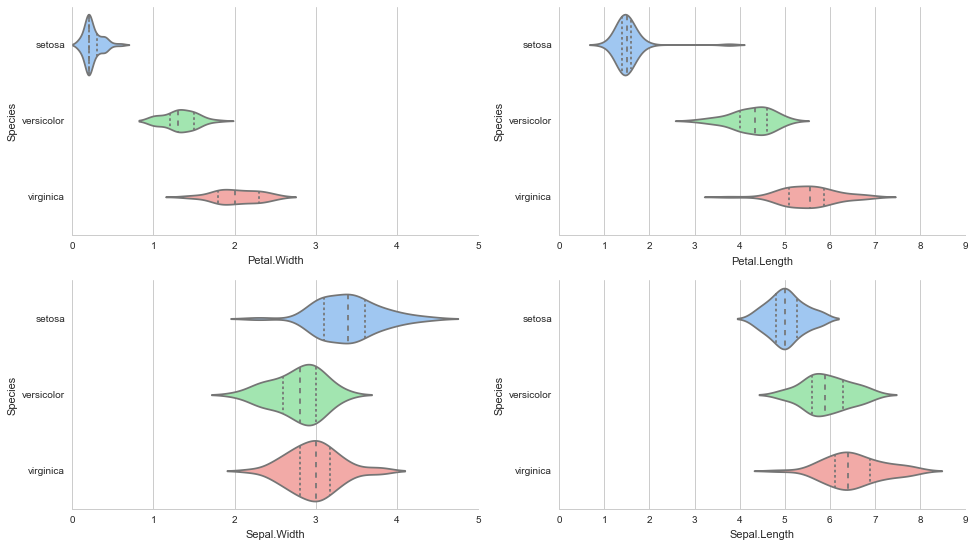

In [27]:
sns.set(style="whitegrid", palette="pastel", color_codes=True); f, axs = plt.subplots(2,2,figsize=(16,9))
def grid_plot(grid_position, variable, xlim): plt.subplot(grid_position); sns.violinplot(x=variable, y="Species", data=data, inner='quartile', orient = 'h').set_xlim(xlim); sns.despine(left=True)
grid_plot(221, "Petal.Width", [0, 5]); grid_plot(223, "Sepal.Width", [0, 5]); grid_plot(222, "Petal.Length", [0, 9]); grid_plot(224, "Sepal.Length", [0, 9])

This visualisation puts the raw statistics in context. Several interesting facts stand out immediately:
1. Our missing values imputation was too simple, e.g. setting the Petal.Length to 3.76 has produced a large (and meaningless) outlier. We need to fix that straight away.
1. Petal dimensions are pretty good all-round discriminators. In this training data - they could completely distinguish the Setosa species and give us pretty good accuracy in distinguishing the other two species.
1. The challenge is going to be in distinguishing between Virginica and Versicolor - they overlap a lot.
1. The inter-quartile ranges hold out some hope though - these are the dotted lines that tell us what the middle-half of the flowers look like. The _Petal_ ranges don't overlap, meaning that we can use them to distinguish a lot of Virginicas from Versicolors, even if we can't distinguish them all.

#### Fixing the imputed values
Fix the imputed values: use a type-based treatment for the missing-values - the mean for that particular type of Iris.

In [28]:
fixed_data = rawdata.groupby('Species').apply(lambda group: group.fillna(group.mean()))

#### Taking it further
An better way to visualise the data would be a view it as an interactive 2D scatterplot matrix like [this](http://shiny.rstudio.com/gallery/kmeans-example.html) or a coloured 3D scatterplot, like [this](http://www.sthda.com/sthda/RDoc/figure/3d-graphics/scatter3d-change-axis-col-r-data-visualization-1.png). However the class assignment was fairly clear about sticking with univariate statistics for now.

## 5.3 Coming up with a rules-based algorithm to help the botanist
### Training a Decision Tree classifier
* We use a decision tree model to help us create a rules-based algorithm.
* The model learns the petal and sepal measurements that best separate the Iris types - these will then form the rules for the algorithm.
* Firstly, we create training (70%) and testing (30%) datasets, using stratification to ensure correctly-balanced proportions of iris types in each dataset. This will give 35 samples of each Iris type for training and 15 for test - about as small as either set can accommodate. 
* We then train the decision tree, using cross-validation to ensure it generalises well, and test its accuracy against our test set.

In [29]:
samples_train, samples_test, labels_train, labels_test = train_test_split(fixed_data.drop('Species', axis=1),fixed_data['Species'], test_size=0.3, random_state=2, stratify=fixed_data['Species']) 

### Determining the optimal depth of rules using grid-search and cross-validation
* To determine the optimal depth of Rules, we will train a model with one level of rules, then train one with 2 levels, etc... up to 10 levels. Technically: we perform a simple grid-search to determine the optimal tree-depth.
* To ensure these models generalise well, we actually train each one multiple times and only look at the _average_ accuracy. Technically: we perform a k-fold, stratified cross-validation (Stone 1974), using 10 folds as recommended by Kohavi (1995). This divides the dataset into 10 'folds', holding back one fold as testing data and using the remaining 9 as training data. This is repeated 10 times, using a different fold for testing each time.  When all is complete, the estimate of the error is taken as the average error across the folds.  (Rodriguez, Perez et al. 2010)
* _Note:_ If we were looking at multiple classifiers, cross-fold validation could be used to identify the best one (Kohavi, 1995).

In [30]:
depth_range = range(1,10); dt_clf_scores = []; cvStrat = cross_validation.StratifiedKFold(labels_train, 10)
for max_depth_parmer in depth_range:
    clf = DecisionTreeClassifier(max_depth=max_depth_parmer,criterion="entropy")
    scores = cross_validation.cross_val_score(clf, samples_train, labels_train, cv=cvStrat, scoring='accuracy')
    print("Average Accuracy of depth %0.1f: %0.2f (+/- %0.2f)" % (max_depth_parmer, scores.mean(), scores.std() * 2))
    dt_clf_scores.append(scores.mean())

Average Accuracy of depth 1.0: 0.67 (+/- 0.00)
Average Accuracy of depth 2.0: 0.91 (+/- 0.16)
Average Accuracy of depth 3.0: 0.93 (+/- 0.15)
Average Accuracy of depth 4.0: 0.89 (+/- 0.16)
Average Accuracy of depth 5.0: 0.89 (+/- 0.15)
Average Accuracy of depth 6.0: 0.89 (+/- 0.16)
Average Accuracy of depth 7.0: 0.90 (+/- 0.17)
Average Accuracy of depth 8.0: 0.90 (+/- 0.15)
Average Accuracy of depth 9.0: 0.88 (+/- 0.14)


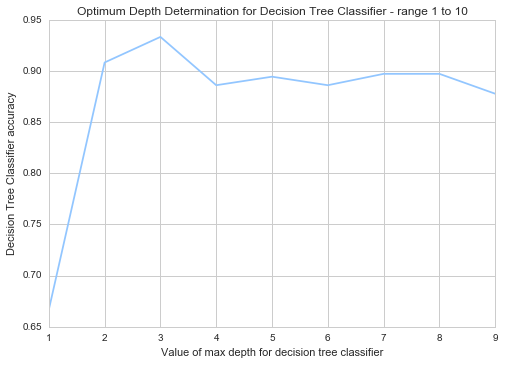

In [31]:
# print the means scores and accuracy
plt.plot(depth_range, dt_clf_scores); plt.title("Optimum Depth Determination for Decision Tree Classifier - range 1 to 10"); plt.xlabel('Value of max depth for decision tree classifier');  plt.ylabel('Decision Tree Classifier accuracy')

In [32]:
best_clf = DecisionTreeClassifier(max_depth=3,criterion="entropy"); best_clf.fit(samples_train,labels_train)
print("Testing model against test data: Accuracy = %.1f%%" % (100 * accuracy_score(labels_test, best_clf.predict(samples_test))))

Testing model against test data: Accuracy = 95.6%


**Conclusion: ** We find that a rules depth of 3 achieves an *average* accuracy of 93.3% in training and 95.6% on the data we held back for testing. Adding more levels of rules does not improve accuracy, it just increases the risk of over-fitting the model to this particular dataset.

## 6. Results presentation and action

### Obtaining the Rules
We could not find any tools for extracting the rules from the model.  However, we did find one tool that enables us to visualise the rules. Visually it's a little rough, but it's good enough for our purposes.  We can see from the graph below that our hierarchy of rules will be as follows:
* *Level 1:* if (Petal Width <= 0.75cm) then the Iris is a Setosa
* *Level 2:* If (Petal Length > 4.75cm) then the Iris is a Virginica
* *Level 3a:* If (Petal Length <= 4.75cm) AND (Petal Width <= 1.65cm) then the Iris is a Versicolor
* *Level 3b:* * If (Petal Length <= 4.75cm) AND (Petal Width >= 1.65cm) then the Iris is a Virginica
 * *Note: there is only one example for this rule, so we might eliminate it as it may not generalise well.*


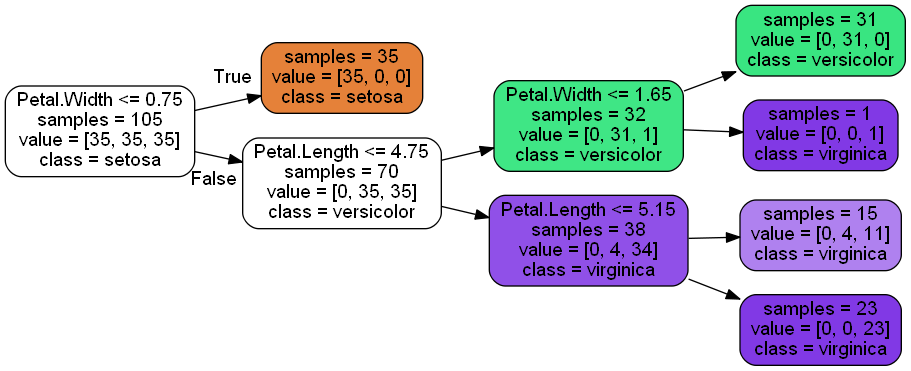

In [33]:
dot_data = StringIO() # Thanks to the scikit-learn documentation for much of this code (http://scikit-learn.org/stable/modules/tree.html#tree)
tree.export_graphviz(best_clf, out_file=dot_data, feature_names=samples_train.columns, class_names=['setosa', 'versicolor', 'virginica'], filled=True, impurity=False, rotate=True, rounded=True)
graph = pydot_ng.graph_from_dot_data(dot_data.getvalue()); Image(graph.create_png())

### Conclusions & Actions

* The botanists required us to help them design an algorithm to identify Iris types from 4 key measurements.
* Our analysis showed that this algorithm is feasible and should correctly (and reliably) identify the Iris types in or around 93% of the time. Interestingly, the Petal measurements alone contain most of the discriminative power. 
* _Action options:_ if the achieved accuracy is acceptable to the botanists, we can put the model we developed to use for them. If not, we can look for further improvements. 

# REFERENCES

Fisher, R.A., 1936. The use of multiple measurements in taxonomic problems. _Annals of eugenics_, 7(2), pp.179-188.

Kohavi, R., 1995, August. A study of cross-validation and bootstrap for accuracy estimation and model selection. In Ijcai (Vol. 14, No. 2, pp. 1137-1145).

RODRIGUEZ, J.D., PEREZ, A. and LOZANO, J.A., 2010. Sensitivity analysis of k-fold cross validation in prediction error estimation. Pattern Analysis and Machine Intelligence, IEEE Transactions on, 32(3), pp. 569-575.

STONE, M., 1974. Cross-validatory choice and assessment of statistical predictions. Journal of the royal statistical society.Series B (Methodological), , pp. 111-147.

Wickham, H. (2014), Tidy Data, Journal of Statistical Software, 59, 1–23.